In [1]:
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from tqdm.auto import tqdm

from bounded_rand_walkers.cpp import (
    bound_map,
    freehand,
    generate_data,
    get_binned_2D,
    get_binned_data,
    get_cached_filename,
)
from bounded_rand_walkers.rad_interp import exact_radii_interp
from bounded_rand_walkers.shaper_generation import (
    gen_rad_shaper,
    gen_rad_shaper_exact,
    gen_shaper2D,
    shaper_map,
)
from bounded_rand_walkers.utils import (
    approx_edges,
    cache_dir,
    get_centres,
    match_ref,
    normalise,
)

mpl.rc_file("matplotlibrc")

### Calculate the shaper function using 2D approach and compare to the analytical function

#### Investigate ideal binning parameters for 2D → radial interpolation

In [2]:
bound_name = "square"

vertices = bound_map[bound_name]()
lim = 1.5


def add_one(x):
    x = x.reshape(1, -1)
    return np.vstack((x, x + 1)).ravel()


bin_samples_cols = list(map(str, np.round(np.linspace(0.005, 0.1, 10), 3)))
mses = {}
bmses = {}
for n_bins in tqdm(np.unique(add_one(np.linspace(41, 151, 30, dtype=np.int64)))):
    f_t_x_edges = f_t_y_edges = np.linspace(-lim, lim, n_bins + 1)
    f_t_x_centres = f_t_y_centres = get_centres(f_t_x_edges)

    num_2d_shaper = gen_shaper2D(vertices, f_t_x_edges, f_t_y_edges, verbose=False)

    mses[n_bins] = {}
    bmses[n_bins] = {}

    for bin_samples_col in bin_samples_cols:
        bin_samples = float(bin_samples_col)
        radii, radial_shaper = exact_radii_interp(
            num_2d_shaper,
            f_t_x_centres,
            f_t_y_centres,
            normalisation="multiply",
            bin_samples=bin_samples,
        )
        # Calculate the shaper function explicitly at multiple radii.
        analytical_shaper = gen_rad_shaper_exact(
            radii,
            vertices=bound_name if bound_name in bound_map else vertices,
            verbose=False,
        )
        analytical_shaper *= radii

        # Align the two.
        radial_shaper = match_ref(
            x=radii, y=radial_shaper, ref_x=radii, ref_y=analytical_shaper
        )

        # Compute mse.
        mses[n_bins][bin_samples_col] = np.mean(
            (analytical_shaper - radial_shaper) ** 2
        )

        # Same computation for l > 0.5
        mask = radii > 0.5
        radii = radii[mask]
        radial_shaper = radial_shaper[mask]
        analytical_shaper = analytical_shaper[mask]

        radial_shaper = match_ref(
            x=radii, y=radial_shaper, ref_x=radii, ref_y=analytical_shaper
        )

        bmses[n_bins][bin_samples_col] = np.mean(
            (analytical_shaper - radial_shaper) ** 2
        )

In [3]:
df1 = pd.DataFrame(mses).T
df1["cat"] = "all"
df2 = pd.DataFrame(bmses).T
df2["cat"] = "high"

In [4]:
df1.describe()

,0.005,0.016,0.026,0.037,0.047,0.058,0.068,0.079,0.089,0.1
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.001045,0.000515,0.000469,0.000492,0.000545,0.000599,0.000684,0.000825,0.000840,0.001144
std,0.001150,0.000866,0.000821,0.000853,0.000913,0.000934,0.000980,0.001089,0.001123,0.001363
min,0.000115,0.000013,0.000025,0.000051,0.000078,0.000115,0.000139,0.000158,0.000192,0.000175
25%,0.000343,0.000094,0.000074,0.000089,0.000108,0.000153,0.000212,0.000319,0.000342,0.000447
50%,0.000652,0.000242,0.000205,0.000216,0.000264,0.000314,0.000364,0.000393,0.000416,0.000603
75%,0.001213,0.000538,0.000463,0.000528,0.000566,0.000643,0.000766,0.000972,0.000971,0.001418
max,0.007195,0.005819,0.005589,0.005933,0.006372,0.006565,0.006828,0.007479,0.007980,0.008988


In [5]:
df2.describe()

,0.005,0.016,0.026,0.037,0.047,0.058,0.068,0.079,0.089,0.1
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.000994,0.000443,0.000378,0.000367,0.000339,0.000330,0.000373,0.000404,0.000335,0.000458
std,0.001021,0.000710,0.000659,0.000690,0.000638,0.000720,0.000698,0.000737,0.000664,0.000778
min,0.000123,0.000009,0.000005,0.000001,0.000003,0.000001,0.000005,0.000013,0.000004,0.000019
25%,0.000333,0.000079,0.000064,0.000052,0.000039,0.000037,0.000026,0.000044,0.000019,0.000087
50%,0.000632,0.000217,0.000164,0.000149,0.000141,0.000107,0.000148,0.000182,0.000129,0.000222
75%,0.001158,0.000464,0.000371,0.000368,0.000340,0.000278,0.000395,0.000435,0.000352,0.000541
max,0.006061,0.004636,0.004379,0.004739,0.004352,0.005150,0.004710,0.005059,0.004638,0.005229


In [6]:
df = pd.concat((df1, df2))
df["odd"] = df.index.values % 2 == 1

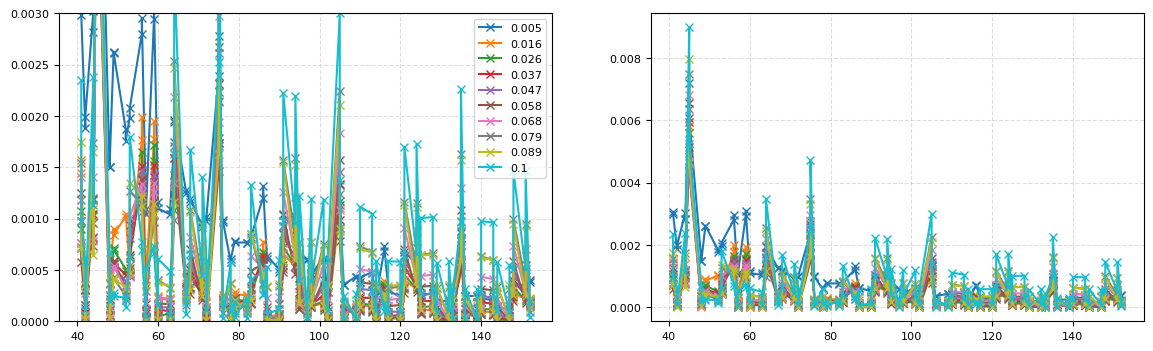

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_df = df.sort_index()
for ax in axes:
    for col in bin_samples_cols:
        ax.plot(plot_df.index.values, plot_df[col].values, label=col, marker="x")
axes[0].set_ylim(0, 0.003)
_ = axes[0].legend(loc="best")

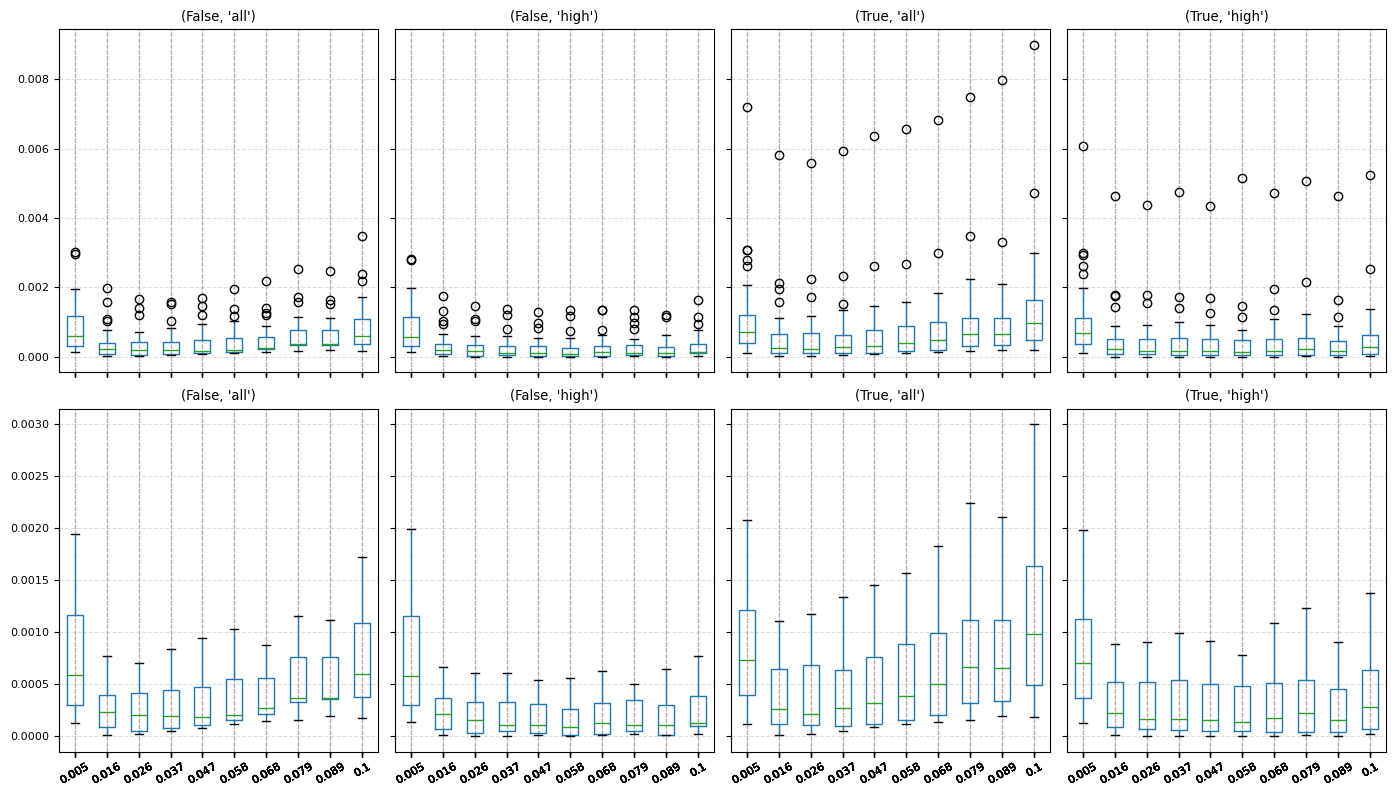

In [8]:
groupby = df.groupby(["odd", "cat"])
fig, axes = plt.subplots(2, len(groupby), sharex=True, figsize=(14, 8), sharey="row")

for ((name, grouped), axes) in zip(groupby, axes.T):
    for ax, b in zip(axes, [True, False]):
        grouped[bin_samples_cols].boxplot(ax=ax, showfliers=b, rot=30)
        ax.set_title(name)

fig.tight_layout()

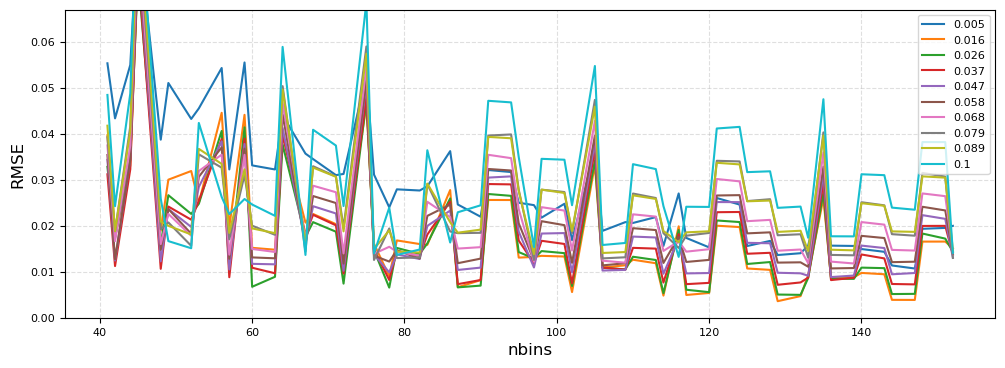

In [9]:
plt.figure(figsize=(12, 4))
for col in bin_samples_cols:
    sel = df[df["cat"] == "all"][col]
    plt.plot(sel.index, np.sqrt(sel.values), label=col)
plt.ylim(0, np.sqrt(sel.quantile(0.98)))
plt.xlabel("nbins")
plt.ylabel("RMSE")
_ = plt.legend()

### Actually calculate the shaper function both ways

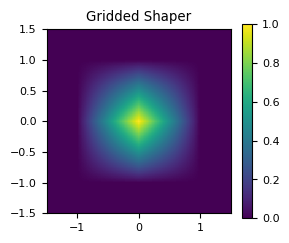

In [10]:
bound_name = "square"

vertices = bound_map[bound_name]()

n_bins = 300
lim = 1.5
f_t_x_edges = f_t_y_edges = np.linspace(-lim, lim, n_bins + 1)
f_t_x_centres = f_t_y_centres = get_centres(f_t_x_edges)

num_2d_shaper = gen_shaper2D(vertices, f_t_x_edges, f_t_y_edges)

plt.figure()
plt.pcolormesh(f_t_x_edges, f_t_y_edges, num_2d_shaper)
plt.axis("scaled")
plt.colorbar()
_ = plt.title("Gridded Shaper")

# Extract shaper from 2D shaper values.
radii, radial_shaper = exact_radii_interp(
    num_2d_shaper,
    f_t_x_centres,
    f_t_y_centres,
    normalisation="multiply",
    bin_width=0.02,
)

radii2, radial_shaper2 = exact_radii_interp(
    num_2d_shaper,
    f_t_x_centres,
    f_t_y_centres,
    normalisation="multiply",
    bin_samples=None,
)

# Calculate the shaper function explicitly at multiple radii.
shaper_radii = np.linspace(0, np.max(radii), 100)
shaper_rad = gen_rad_shaper_exact(
    shaper_radii, vertices=bound_name if bound_name in bound_map else vertices
)

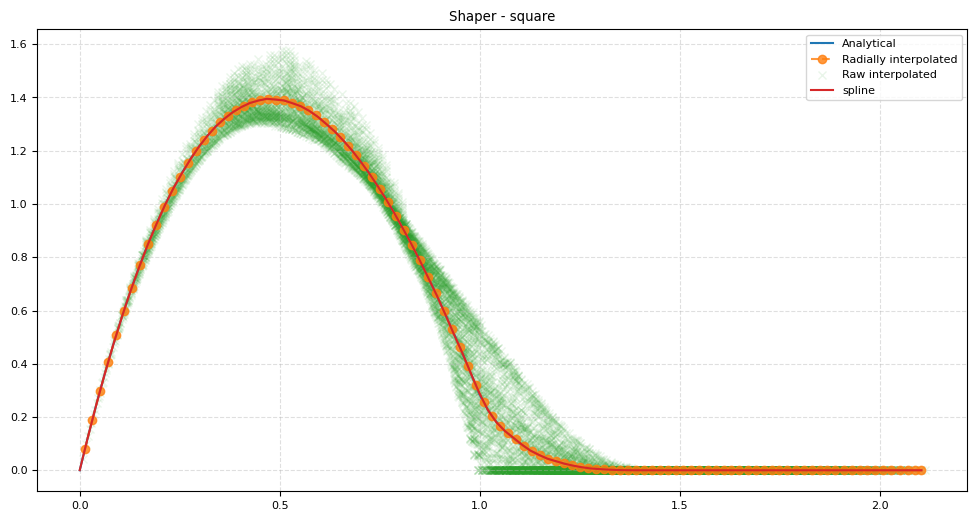

In [11]:
plt.figure(figsize=(12, 6))

plt.plot(
    shaper_radii,
    normalise(shaper_radii, shaper_rad * shaper_radii),
    label="Analytical",
    zorder=2,
    c="C0",
)
norm_radial_shaper = normalise(radii, radial_shaper)
plt.plot(
    radii,
    norm_radial_shaper,
    label="Radially interpolated",
    marker="o",
    linestyle="--",
    alpha=0.8,
    zorder=3,
    c="C1",
)
plt.plot(
    radii2,
    match_ref(
        x=radii2,
        y=radial_shaper2,
        ref_x=radii,
        ref_y=norm_radial_shaper,
        interpolate=True,
    ),
    label="Raw interpolated",
    marker="x",
    linestyle="",
    alpha=0.1,
    zorder=1,
    c="C2",
)

spl = UnivariateSpline(radii, norm_radial_shaper, s=0)
plt.plot(
    shaper_radii,
    spl(shaper_radii),
    c="C3",
    zorder=4,
    label="spline",
)

plt.legend(loc="best")
_ = plt.title(f"Shaper - {bound_name}")

### Calculate the shaper function using 2D approach for the irregular boundary

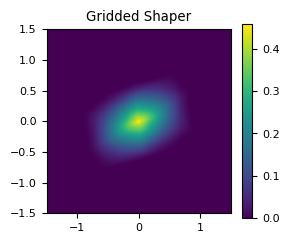

In [12]:
bound_name = "irregular"

vertices = bound_map[bound_name]()

n_bins = 350
lim = 1.5
f_t_x_edges = f_t_y_edges = np.linspace(-lim, lim, n_bins + 1)
f_t_x_centres = f_t_y_centres = get_centres(f_t_x_edges)

num_2d_shaper = gen_shaper2D(vertices, f_t_x_edges, f_t_y_edges)

plt.figure()
plt.pcolormesh(f_t_x_edges, f_t_y_edges, num_2d_shaper)
plt.axis("scaled")
plt.colorbar()
_ = plt.title("Gridded Shaper")

In [13]:
# Extract shaper from 2D shaper values.
radii, radial_shaper = exact_radii_interp(
    num_2d_shaper,
    f_t_x_centres,
    f_t_y_centres,
    normalisation="multiply",
    bin_width=0.02,
)
raw_radii, raw_radial_shaper = exact_radii_interp(
    num_2d_shaper,
    f_t_x_centres,
    f_t_y_centres,
    normalisation="multiply",
)

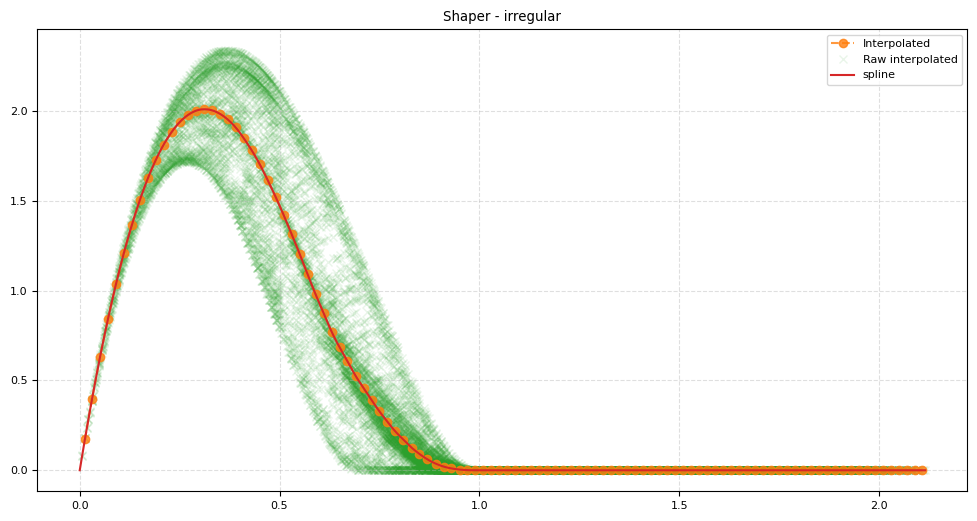

In [14]:
plt.figure(figsize=(12, 6))

norm_radial_shaper = normalise(radii, radial_shaper)
plt.plot(
    radii,
    norm_radial_shaper,
    label="Interpolated",
    marker="o",
    linestyle="--",
    alpha=0.8,
    zorder=3,
    c="C1",
)
plt.plot(
    raw_radii,
    match_ref(
        x=raw_radii,
        y=raw_radial_shaper,
        ref_x=radii,
        ref_y=norm_radial_shaper,
        interpolate=True,
    ),
    label="Raw interpolated",
    marker="x",
    linestyle="",
    alpha=0.1,
    zorder=1,
    c="C2",
)
spl = UnivariateSpline(radii, norm_radial_shaper, s=0)
plot_radii = np.linspace(0, np.max(raw_radii), 500)
plt.plot(
    plot_radii,
    spl(plot_radii),
    c="C3",
    zorder=4,
    label="spline",
)
plt.legend(loc="best")
_ = plt.title(f"Shaper - {bound_name}")